**Data Inspection, Cleaning and Preparation**

In [3]:
# Import the necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import numpy as np

In [4]:
# Load the forecast demand data
forecast_demand_df = pd.read_csv(
    'data/forecastdemand_nsw.csv',
    sep=',',
    header=0,
    dtype={'PREDISPATCHSEQNO': str, 'PERIODID': int, 'FORECASTDEMAND': float},
    parse_dates=['LASTCHANGED', 'DATETIME']
)

# Load the temperature data
temperature_df = pd.read_csv('data/temperature_nsw.csv', sep=',', header=0)


# Load the total demand data
total_demand_df = pd.read_csv('data/totaldemand_nsw.csv', sep=',', header=0,
                              parse_dates=['DATETIME'],
                              dtype={'TOTALDEMAND': float,'REGIONID': str}
                              )
# Load the wildfiredata
wildfire_df = pd.read_csv('data/NSW_fire_history_wildfire.csv', sep=',', header=0, parse_dates=['StartDate','EndDate'],)

In [55]:
wildfire_df.head()
wildfire_df

,FID,FireName,FireNo,Label,StartDate,EndDate,AreaHa,PerimeterM,Verdate,Type,Season,ID,Year,Year_Con,Shape__Area,Shape__Length,Days
0,1,,,1968-69 Prescribed Burn,1968-10-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,2.184770,1548.960666,26/03/2020,Prescribed Burn,1968-69,0,1968,1968/01/01 00:00:00+00,2.186876e+04,1549.703956,NaN
1,2,,,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,299.985464,8615.637120,26/03/2020,Prescribed Burn,1970-71,1,1970,1970/01/01 00:00:00+00,2.996520e+06,8610.851395,NaN
2,3,,70/161,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,309.025645,20657.633990,26/03/2020,Prescribed Burn,1970-71,2,1970,1970/01/01 00:00:00+00,3.085906e+06,20643.091300,NaN
3,4,,70/161,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,316.104427,20353.231750,26/03/2020,Prescribed Burn,1970-71,3,1970,1970/01/01 00:00:00+00,3.156677e+06,20339.165560,NaN
4,5,,70/160,1970-71 Prescribed Burn,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,28.484088,2695.160793,26/03/2020,Prescribed Burn,1970-71,4,1970,1970/01/01 00:00:00+00,2.844296e+05,2693.214793,NaN


In [7]:
df_check(forecast_demand_df)

NameError: name 'df_check' is not defined

In [6]:
forecast_demand_df.head(100)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
0,2009123018,NSW1,71,7832.04,2009-12-30 12:31:49,2010-01-01 00:00:00
1,2009123019,NSW1,70,7832.04,2009-12-30 13:01:43,2010-01-01 00:00:00
2,2009123020,NSW1,69,7832.03,2009-12-30 13:31:36,2010-01-01 00:00:00
3,2009123021,NSW1,68,7832.03,2009-12-30 14:01:44,2010-01-01 00:00:00
4,2009123022,NSW1,67,7830.96,2009-12-30 14:31:35,2010-01-01 00:00:00
...,...,...,...,...,...,...
95,2009123042,NSW1,48,7715.68,2009-12-31 00:31:25,2010-01-01 00:30:00
96,2009123043,NSW1,47,7716.52,2009-12-31 01:01:17,2010-01-01 00:30:00
97,2009123044,NSW1,46,7716.82,2009-12-31 01:31:21,2010-01-01 00:30:00
98,2009123045,NSW1,45,7709.87,2009-12-31 02:01:23,2010-01-01 00:30:00


In [26]:
df_check(total_demand_df)

             NaN Count  Unique Count  Zero Count       Data Type
DATETIME             0        196513           0  datetime64[ns]
TOTALDEMAND          0        160515           0         float64
REGIONID             0             1           0          object


In [29]:
df_check(temperature_df)

             NaN Count  Unique Count  Zero Count Data Type
LOCATION             0             1           0    object
TEMPERATURE          0           439           0   float64


In [28]:
# Convert DATETIME in temperature_df to datetime64[ns] and set it as the index
temperature_df['DATETIME'] = pd.to_datetime(temperature_df['DATETIME'])
temperature_df.set_index('DATETIME', inplace=True)

In [30]:
# Set DATETIME as the index for forecast_demand_df and total_demand_df
forecast_demand_df.set_index('DATETIME', inplace=True)
total_demand_df.set_index('DATETIME', inplace=True)

In [31]:
# Merge the dataframes on DATETIME
merged_df = forecast_demand_df[['FORECASTDEMAND']].merge(
    total_demand_df[['TOTALDEMAND']],
    left_index=True, right_index=True
).merge(
    temperature_df[['TEMPERATURE']],
    left_index=True, right_index=True
)

In [43]:
# Create a 'Season' column

# Extract Year and Season from DATETIME
merged_df['Year'] = merged_df.index.year
merged_df['Month'] = merged_df.index.month

def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Summer'
    elif date.month in [3, 4, 5]:
        return 'Autumn'
    elif date.month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

merged_df['Season'] = merged_df.index.map(get_season)


In [33]:
# Statistical Summary
summary_stats = merged_df.describe()

In [34]:
summary_stats

,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE
count,1.080401e+07,1.080401e+07,1.080401e+07
mean,8.070308e+03,8.073427e+03,1.731452e+01
std,1.316296e+03,1.309579e+03,5.822771e+00
min,4.422460e+03,5.074630e+03,-1.300000e+00
25%,7.081280e+03,7.100100e+03,1.320000e+01
50%,8.011830e+03,8.005710e+03,1.760000e+01
75%,8.930110e+03,8.918670e+03,2.130000e+01
max,1.473666e+04,1.457986e+04,4.470000e+01


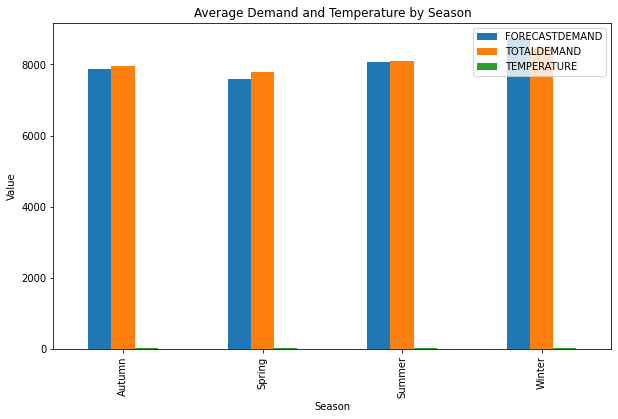

In [35]:
# Seasonal Analysis - Group by season and visualize average demand and temperature
seasonal_means = merged_df.groupby('Season').mean()

# Plot seasonal means for total and forecast demand, and temperature
seasonal_means[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].plot(kind='bar', figsize=(10, 6))
plt.title('Average Demand and Temperature by Season')
plt.ylabel('Value')
plt.show()

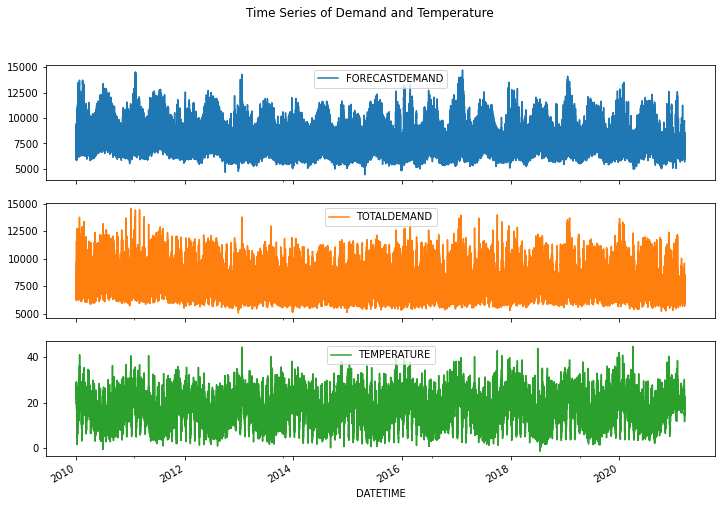

In [36]:
#  Trend Analysis - Plot time series of demand and temperature
merged_df[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].plot(subplots=True, figsize=(12, 8), title='Time Series of Demand and Temperature')
plt.show()

In [37]:
# 4. Correlation Analysis
corr_matrix = merged_df[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].corr()

In [38]:
corr_matrix

,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE
FORECASTDEMAND,1.000000,0.819821,0.170750
TOTALDEMAND,0.819821,1.000000,0.140371
TEMPERATURE,0.170750,0.140371,1.000000


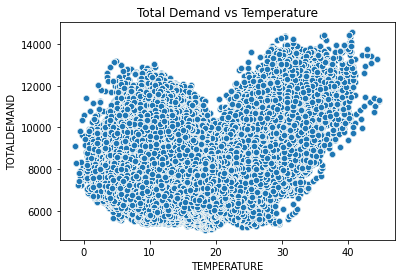

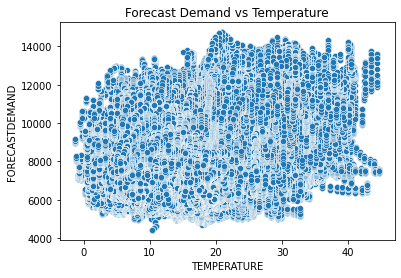

In [39]:
# 5. Scatter plot for demand vs. temperature
sns.scatterplot(data=merged_df, x='TEMPERATURE', y='TOTALDEMAND')
plt.title('Total Demand vs Temperature')
plt.show()

sns.scatterplot(data=merged_df, x='TEMPERATURE', y='FORECASTDEMAND')
plt.title('Forecast Demand vs Temperature')
plt.show()

In [40]:
# 6. Time-lagged analysis (shifting temperature data by a day)
merged_df['Temp_Lag_1D'] = merged_df['TEMPERATURE'].shift(1)
lag_corr = merged_df[['TOTALDEMAND', 'Temp_Lag_1D']].corr()

In [41]:
lag_corr

,TOTALDEMAND,Temp_Lag_1D
TOTALDEMAND,1.000000,0.140424
Temp_Lag_1D,0.140424,1.000000


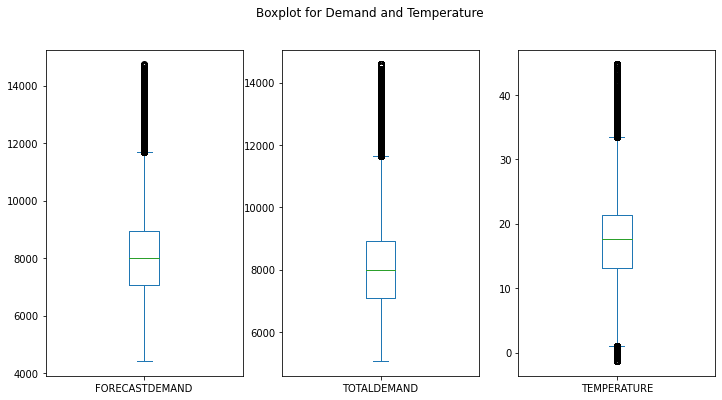

In [42]:
#  Outlier Detection - Boxplot for temperature and demand
merged_df[['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE']].plot(kind='box', subplots=True, layout=(1,3), figsize=(12, 6), title='Boxplot for Demand and Temperature')
plt.show()

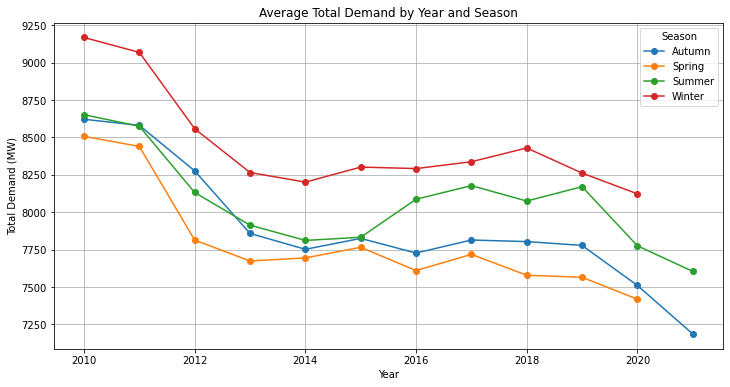

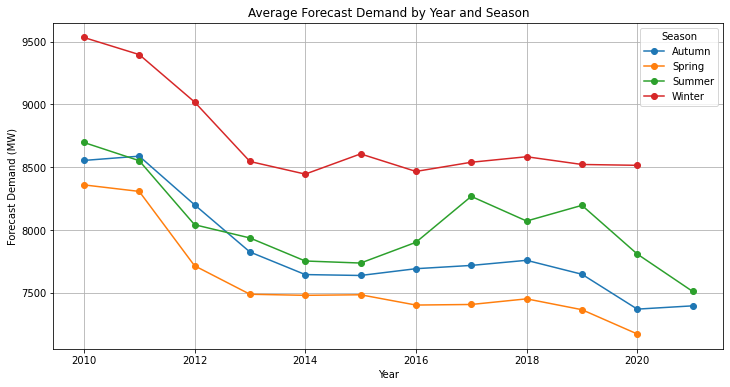

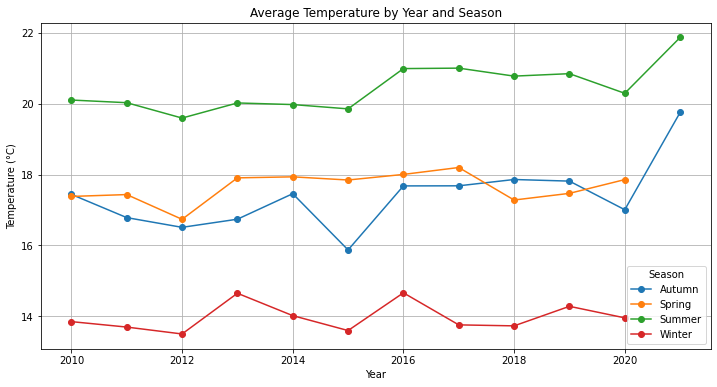

In [44]:
# Group by Year and Season and calculate the mean for each group
seasonal_yearly_means = merged_df.groupby(['Year', 'Season']).mean()

# Visualize the average demand and temperature year by year for each season
# Plot for Total Demand
seasonal_yearly_means.unstack(level=1)['TOTALDEMAND'].plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Total Demand by Year and Season')
plt.ylabel('Total Demand (MW)')
plt.legend(title='Season')
plt.grid(True)
plt.show()

# Plot for Forecast Demand
seasonal_yearly_means.unstack(level=1)['FORECASTDEMAND'].plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Forecast Demand by Year and Season')
plt.ylabel('Forecast Demand (MW)')
plt.legend(title='Season')
plt.grid(True)
plt.show()

# Plot for Temperature
seasonal_yearly_means.unstack(level=1)['TEMPERATURE'].plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Average Temperature by Year and Season')
plt.ylabel('Temperature (°C)')
plt.legend(title='Season')
plt.grid(True)
plt.show()

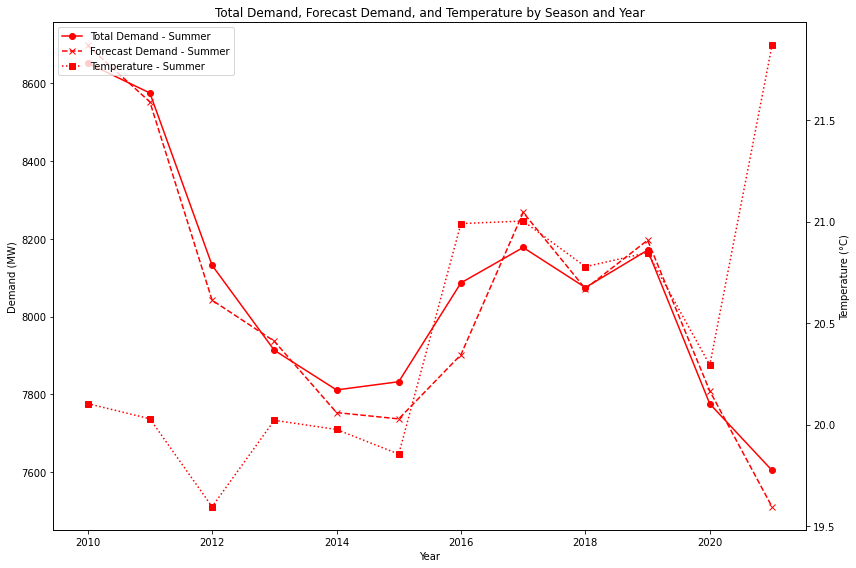

In [51]:
# Extract Year and Season from DATETIME
merged_df['Year'] = merged_df.index.year
merged_df['Season'] = merged_df.index.map(get_season)

# Group by both Year and Season and calculate the mean for each group
seasonal_yearly_means = merged_df.groupby(['Year', 'Season']).mean()

# Step 3: Unstack the multi-index dataframe for easier plotting
seasonal_yearly_means_unstacked = seasonal_yearly_means.unstack(level='Season')

# Define a color palette for the seasons
season_palette = {
    'Summer': 'red',
    'Autumn': 'orange',
    'Winter': 'blue',
    'Spring': 'green'
}

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot total demand and forecast demand on the left y-axis
for season in ['Summer']:
    ax1.plot(seasonal_yearly_means_unstacked.index, 
             seasonal_yearly_means_unstacked['TOTALDEMAND'][season], 
             label=f'Total Demand - {season}', 
             color=season_palette[season], linestyle='-', marker='o')
    ax1.plot(seasonal_yearly_means_unstacked.index, 
             seasonal_yearly_means_unstacked['FORECASTDEMAND'][season], 
             label=f'Forecast Demand - {season}', 
             color=season_palette[season], linestyle='--', marker='x')

# Set the labels and title for the left y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Demand (MW)')
ax1.set_title('Total Demand, Forecast Demand, and Temperature by Season and Year')

# Create the second y-axis for temperature
ax2 = ax1.twinx()

# Plot temperature on the right y-axis
for season in ['Summer']:
    ax2.plot(seasonal_yearly_means_unstacked.index, 
             seasonal_yearly_means_unstacked['TEMPERATURE'][season], 
             label=f'Temperature - {season}', 
             color=season_palette[season], linestyle=':', marker='s')

# Set the label for the right y-axis
ax2.set_ylabel('Temperature (°C)')

# Combine the legends for both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

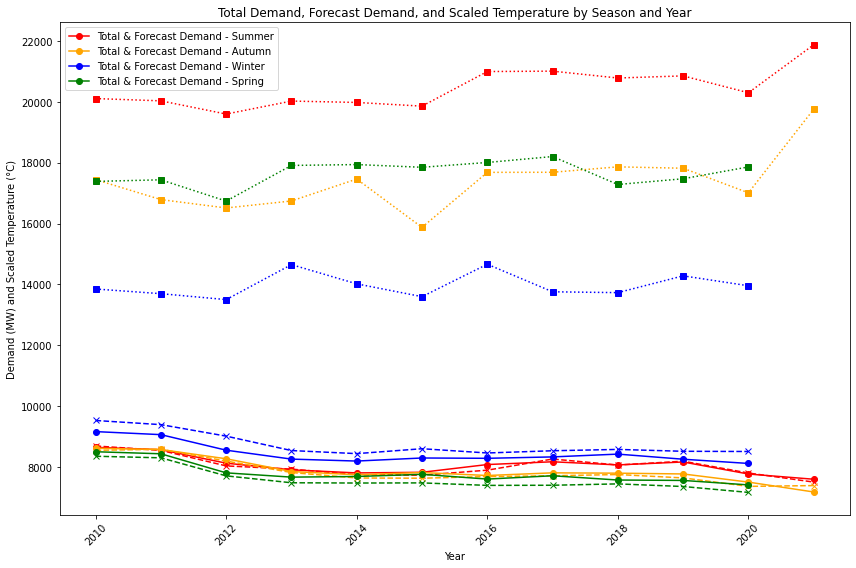

In [49]:
#  Extract Year and Season from DATETIME
merged_df['Year'] = merged_df.index.year
merged_df['Season'] = merged_df.index.map(get_season)

#  Group by both Year and Season and calculate the mean for each group
seasonal_yearly_means = merged_df.groupby(['Year', 'Season']).mean()

# Unstack the multi-index dataframe for easier plotting
seasonal_yearly_means_unstacked = seasonal_yearly_means.unstack(level='Season')

# Define a color palette for the seasons
season_palette = {
    'Summer': 'red',
    'Autumn': 'orange',
    'Winter': 'blue',
    'Spring': 'green'
}

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot all variables for each season with one line per season
for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
    # Normalize temperature to the scale of demand for easier comparison
    temp_scaled = seasonal_yearly_means_unstacked['TEMPERATURE'][season] * 1000  # Scale temperature
    ax1.plot(seasonal_yearly_means_unstacked.index, 
             seasonal_yearly_means_unstacked['TOTALDEMAND'][season], 
             label=f'Total & Forecast Demand - {season}', 
             color=season_palette[season], linestyle='-', marker='o')
    
    ax1.plot(seasonal_yearly_means_unstacked.index, 
             seasonal_yearly_means_unstacked['FORECASTDEMAND'][season], 
             color=season_palette[season], linestyle='--', marker='x')
    
    ax1.plot(seasonal_yearly_means_unstacked.index, 
             temp_scaled, 
             color=season_palette[season], linestyle=':', marker='s')

# Set the labels and title for the left y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Demand (MW) and Scaled Temperature (°C)')
ax1.set_title('Total Demand, Forecast Demand, and Scaled Temperature by Season and Year')

# Combine the legend into one
ax1.legend(loc='upper left')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()